## Twitter Archive

In [65]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from datetime import datetime
from matplotlib import pyplot as plt
from functools import reduce
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import csv

Twitter Archive includes a csv of tweets, so we'll use that

##### Simple Cleanse 

In [92]:
# csv is in poor shape, and we need to strip some newline data
fname = "../archive_dec16/tweets.csv"
cname = "../archive_dec16/cleantweets.csv"

# how we want to clean some srings (uses reduce)
repls = {'\n': '', ',':''}

def string_clean(text):
    for i, j in repls.items():
        text = text.replace(i, j)
    return text

with open(fname, "r", encoding="utf8") as input, open(cname, "w", encoding='utf-8', newline='') as output:
    w = csv.writer(output)
    for record in csv.reader(input):
        clean_row = tuple(string_clean(s) for s in record)
        # in this simple example we only care for timestamp & text
        w.writerow((clean_row[3],clean_row[5]))

##### Load and transform data

we need to transform the data into relevant info for this example, something like:  

  <p style="text-align: center;">date : <em>tweeting score</em> </p>
  
  tweeting score will include a total count of tweets as well as total words for the day, for now it'll just be a simple calculation
  
  <p style="text-align: center;"><em>single day tweeting score</em> = total tweets + total words </p>

In [127]:

# dealing with timestamps so we'll need to convert
str2date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S %z')
str2int = lambda x: len(x)

tweet_data = np.genfromtxt(cname, dtype=None, delimiter=',',
                           skip_header=1,
                           converters = {0: str2date,1: str2int},
                           encoding="utf8")

num_tweets = len(tweet_data)
    
print(num_tweets)
print(tweet_data[1:10])

375
[(datetime.datetime(2018, 12, 16, 0, 0),  29)
 (datetime.datetime(2018, 12, 16, 0, 0),  51)
 (datetime.datetime(2018, 12, 16, 0, 0), 206)
 (datetime.datetime(2018, 12, 13, 0, 0),  57)
 (datetime.datetime(2018, 12, 10, 0, 0),  89)
 (datetime.datetime(2018, 12, 10, 0, 0),  60)
 (datetime.datetime(2018, 12, 9, 0, 0),  56)
 (datetime.datetime(2018, 12, 9, 0, 0),  63)
 (datetime.datetime(2018, 12, 9, 0, 0),  43)]


Shape looks right (I haven't hit the 1k mark yet...), now we need to aggregate all of the same-day tweets and their counts

In [165]:
agg_data = {}

tweet_weight = 1000 # idk, act of tweeting itself should count for something

# simple dates
for item in tweet_data:
    key = item[0].strftime('%m/%d/%Y')
    if key in agg_data:
        agg_data[key] = agg_data[key] + item[1] + tweet_weight
    else:
        agg_data[key] = item[1] + tweet_weight

dates = np.array(list(agg_data.keys()))
tscores = np.array(list(agg_data.values()))

# print(len(dates), len(tscores))
n_tscores = len(tscores)

##### Simple Visualize

(0, 235)

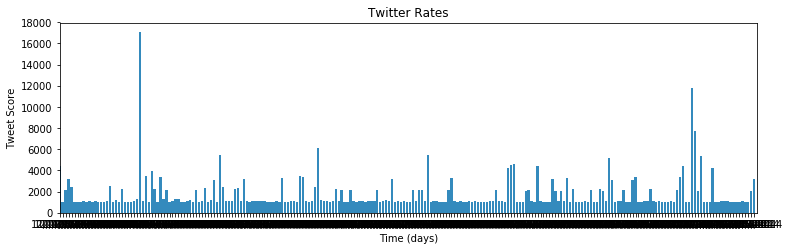

In [173]:
# figsize(12.5, 3.5)

plt.bar(dates, tscores, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Tweet Score")
plt.title("Twitter Rates")
plt.xlim(0, n_tscores)
